In [10]:
import subprocess
import os
import glob
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import astropy.units as u
import pandas as pd

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

from astropy.time import Time
from astropy.coordinates import SkyCoord
from scipy.special import iv
from astropy.constants import c

# Formatting opinions
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'serif'

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.width'] = 2.5
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 9.0
mpl.rcParams['ytick.minor.size'] = .0

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.major.width'] = 2.5
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.major.size'] = 9.0
mpl.rcParams['xtick.minor.size'] = 4.0
mpl.rcParams['xtick.labelbottom'] = True


mpl.rcParams['axes.linewidth'] = 1.5

# Function for putting UTC on top of axis
def FormatAxis(ax, mjd, dt = 10, interval=60):
    ax[0].set_xlabel('Observing Date (UTC)', fontfamily='serif')  
    ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax[0].set_xlim(Time(mjd[0] - dt, format='mjd').datetime,Time(mjd[-1] + dt, format='mjd').datetime)
    ax[0].xaxis.set_label_position('top') 
    xformatter = mdates.DateFormatter('%Y-%m-%d')
    plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
    ax[0].tick_params(axis='x', which='major',rotation=15, labeltop=True, labelbottom=False)
    xlabels = ax[0].get_xticklabels()
    ax[0].set_xticklabels(xlabels, rotation=15, ha='left')

    # Format secondary x-axis
    mjd_ax = ax[-1].secondary_xaxis('bottom', functions=(plot2mjd, mjd2plot))
    mjd_ax.set_xlabel('Observing Date (MJD)', fontfamily='serif')  
    mjd_ax.tick_params(which='major', direction='in', length = 0.0, width = 0.0)
    plt.draw()

    # Extract the labels
    mjd_ticks = []
    labels = ax[0].get_xticklabels(which='major')
    for lab in labels:
        mjd_ticks.append(lab.get_text() + 'T00:00:00')

    # Line up MJD and Datetime labels 
    mjd_ticks = (Time(mjd_ticks, format='isot').mjd).astype(int)
    mjd_ax.set_xticks(mjd_ticks, labels = mjd_ticks)
    
def plot2mjd(t):
    '''Convert from matplotlib plot date to mjd'''
    return Time(t, format="plot_date", scale='utc').mjd

def mjd2plot(mjd):
    '''Convert from mjd to matplotlib plot'''
    return Time(mjd, format="mjd", scale='utc').plot_date

def initialize_maxi_curve(fname, cutoff=10):
    data = np.genfromtxt(fname)
    data[:,0] = (data[:,1] * 0.5 + data[:,0] * 0.5)
    data[:,1] = np.ones(data.shape[0]) * 0.5

    return data[cutoff:,:]

## Load in the radio data and calculate spectral indices

In [7]:
data = pd.read_csv('files/SW1727_Radio.csv')
data['Midpoint (DT)'] = Time(data['Midpoint (MJD)'], format='mjd').datetime

# Initialize lists to contain information
alpha_arr = []
alpha_mjd = []
alpha_err_arr = []
alpha_telescope = []

# Iterate through telescopes as we only calculate strictly simultaneous INTER-band spectral indices
for mjd in np.unique(data['Midpoint (MJD)']):

    # Get Telescope names that correspond to this date
    index = (data['Midpoint (MJD)'] == mjd)
    tele = data['Telescope'][index]

    # Make sure there is no-cross talk between telescopes
    if len(np.unique(tele)) > 1:
        print('Cross Talk Between the Telescopes')
        break

    tele = np.unique(tele)[0]
    
    # Separate out the values
    flux = np.array(data['Integrated flux (mJy)'][index])
    flux_err = np.array(data['Error (mJy)'][index])
    freq = np.array(data['Frequency (GHz)'][index])    

    # Order in frequency
    argsort = np.argsort(freq)
    freq = freq[argsort]
    flux = flux[argsort]
    flux_err = flux_err[argsort]
    
    # Two-point spectral index
    if flux.size == 2:

        # Calculate two-point spectral index
        alpha = np.log(flux[1] / flux[0]) / np.log(freq[1] / freq[0]) 
        alpha_err = ((flux_err[1] / flux[1]) ** 2 + (flux_err[0] / flux[0]) ** 2) ** 0.5 / np.log(freq[1] / freq[0])    

        # Append to array
        alpha_telescope.append(tele)
        alpha_mjd.append(mjd)
        alpha_arr.append(alpha)
        alpha_err_arr.append(alpha_err)    # Calculate y-int

        # Make fit 'list' for plotting purposes 
        fit = [alpha, 0.0]
        fit[1] = np.log(flux[1]) - fit[0] * np.log(freq[1])

    # Multi-point linear fit for spectral index
    if flux.size > 2:

        # Simple linear fit
        logflux  = np.log(flux)
        dlogflux = abs(flux_err / flux)
        logfreq  = np.log(freq)
        fit, cov = np.polyfit(logfreq, logflux, w = 1. / dlogflux, deg = 1, cov = 'unscaled')

        # Separate alpha values
        alpha = fit[0]
        alpha_err = cov[0,0] ** 0.5

        alpha_telescope.append(tele)
        alpha_mjd.append(mjd)        
        alpha_arr.append(alpha)
        alpha_err_arr.append(alpha_err)

    # Plot spectral index if desired
    plot = True
    if flux.size > 1 and plot:
        if not os.path.exists('spectral_pngs/'):
            os.mkdir('spectral_pngs/') 
        fig,ax=plt.subplots(figsize=(6,6))
        ax.errorbar(np.log(freq), np.log(flux), yerr = abs(flux_err / flux), fmt='o')
        ax.errorbar(np.log(freq), np.log(freq) * fit[0] + fit[1], fmt='-', c = 'r', label = 'alpha={:.3f} +/- {:.3f}'.format(fit[0], alpha_err))
        ax.set_ylabel('Ln Flux Density (log mJy)')
        ax.set_xlabel('Ln Frequency (log GHz)')
        ax.legend()
        plt.savefig('spectral_pngs/mjd{}_{}.png'.format(mjd, tele))
        plt.clf()
        plt.close()        


# Numpy-ize
alpha_arr       = np.array(alpha_arr)       
alpha_mjd       = np.array(alpha_mjd)       
alpha_err_arr   = np.array(alpha_err_arr)   
alpha_telescope = np.array(alpha_telescope)

## Calculate a 10-GHz scaled lightcurve using the nearest spectral index

In [8]:
# Iterate through the Time array and solve for the nearest index
nearest_index = []
for mjd in data['Midpoint (MJD)']: 
    nearest_index.append(np.argmin(abs(alpha_mjd - mjd)))

# Nump-ize
nearest_index = np.array(nearest_index)

# Scale the flux according to the spectral index
alpha_scaled = alpha_arr[nearest_index]
alpha_scaled_err = alpha_err_arr[nearest_index]
flux_scaled     = data['Integrated flux (mJy)'] * (10.0 / data['Frequency (GHz)']) ** (alpha_scaled)

# Add error on spectral index in quadrature
flux_scaled_err = (data['Error (mJy)'] * (10.0 / data['Frequency (GHz)']) ** (alpha_scaled) ** 2
                   + (data['Integrated flux (mJy)'] * (10.0 / data['Frequency (GHz)']) ** (alpha_scaled) * np.log(10.0 / data['Frequency (GHz)']) * alpha_scaled_err) ** 2) ** 0.5

# Index that selects epochs with 100 GHz > nu > 10 GHz, and omitt e-Merlin due to VLBI concerns
scaled_index = np.where((data['Frequency (GHz)'] < 100.) & (data['Frequency (GHz)'] > 1.) & (data['Telescope'] != 'e-MERLIN'))[0]

## Make the MAXI/GSC HID from the On-Demand Data Products

In [12]:
# Define relevant functions
def calc_HR(hard, soft):
    HR     = hard[0] / soft[0]
    HR_err = HR * ((soft[1]/soft[0]) ** 2 + (hard[1] / hard[0]) ** 2) ** 0.5

    return [HR, HR_err]

def weighted_average(data): 

    avg     = np.average(data[:,0], weights = data[:,1] ** (-2))
    avg_err = np.sum(data[:,1] ** (-2)) ** (-0.5)

    return [avg, avg_err]


# On-demand products -- http://maxi.riken.jp/mxondem/
maxi_soft  = initialize_maxi_curve('files/Swift_J1727_2.0-6.0keV_gsclc.dat')
maxi_hard = initialize_maxi_curve('files/Swift_J1727_6.0-20.0keV_gsclc.dat')

# Only use the data points after the outburst onset (to ensure measurement of stat. sig. HR values)
index = np.where(maxi_soft[:,2] > 1.0)[0][0] - 1
maxi_soft  = maxi_soft[index:,:]
maxi_hard = maxi_hard[index:,:]

# Calculate total via sum and approximate errors through quadrature addition
maxi_total = maxi_soft[:,[0,1,2,3]] + maxi_hard[:, [0,1,2,3]] 
maxi_total[:,3] = (maxi_soft[:,3] ** 2 + maxi_hard[:, 3] ** 2) ** 0.5

# Split out useful hard, soft, and total components
t_arr = maxi_soft[:,0]
soft  = maxi_soft[:,[2,3]]
hard  = maxi_hard[:,[2,3]]
total = maxi_total[:,[2,3]]

# Initialize 2-D list to store HID information
HID = [[],[],[],[],[],[]]

# Adaptive averaging
k  = 0 
dk = 1
threshold = 3

# This is now going to perform adaptive averaging

# A bin will stop if (in order of importance)
# --- 1. The next bin is > threshold-significance; this avoids over-averaging
# --- 2. You reach a sun-constraint gap
# --- 3. You reach the end of the data
# --- 4. The grouping is > threshold-significance

while True:

    # Calculate averages
    soft_avg  = weighted_average(soft[k:k + dk,:])
    hard_avg  = weighted_average(hard[k:k + dk,:])
    total_avg = weighted_average(total[k:k + dk,:])

    # Check if criteria is met
    if soft_avg[0] >= threshold * soft_avg[1] and hard_avg[0] >= threshold * hard_avg[1]:
        
        t = np.mean(t_arr[k:k + dk])
        dt = (np.amax(t_arr[k:k + dk]) - np.amin(t_arr[k:k + dk])) * 0.5 + 0.5

        HR_i = calc_HR(hard_avg, soft_avg)
        
        HID[0].append(t)
        HID[1].append(dt)
        HID[2].append(HR_i[0])
        HID[3].append(HR_i[1])
        HID[4].append(total_avg[0])
        HID[5].append(total_avg[1])

        k = k + dk
        dk = 1

    # Next run your checks
    else:
        
        # Check if we are at the end of the data -- if so kill the loop and append an upper limit
        if k + dk == len(soft[:,0]):
            break 
        
        # Check if next bin is >threshold-sigma -- if so append a limit for current bin as to not over-average good data
        elif  soft[k + dk, 0] >= threshold * soft[k + dk, 1] and hard[k + dk, 0] >= threshold * hard[k + dk, 1]: 
            
            k = k + dk
            dk = 1      
    
        # Check if there is a massive gap in the data due to sun constraint. Don't average over these gap
        elif abs(t_arr[k + dk - 1] - t_arr[k + dk]) > 7.:
            
            k = k + dk
            dk = 1    

        else:
            dk += 1
    

# Numpize the HID
HID = np.array(HID).T

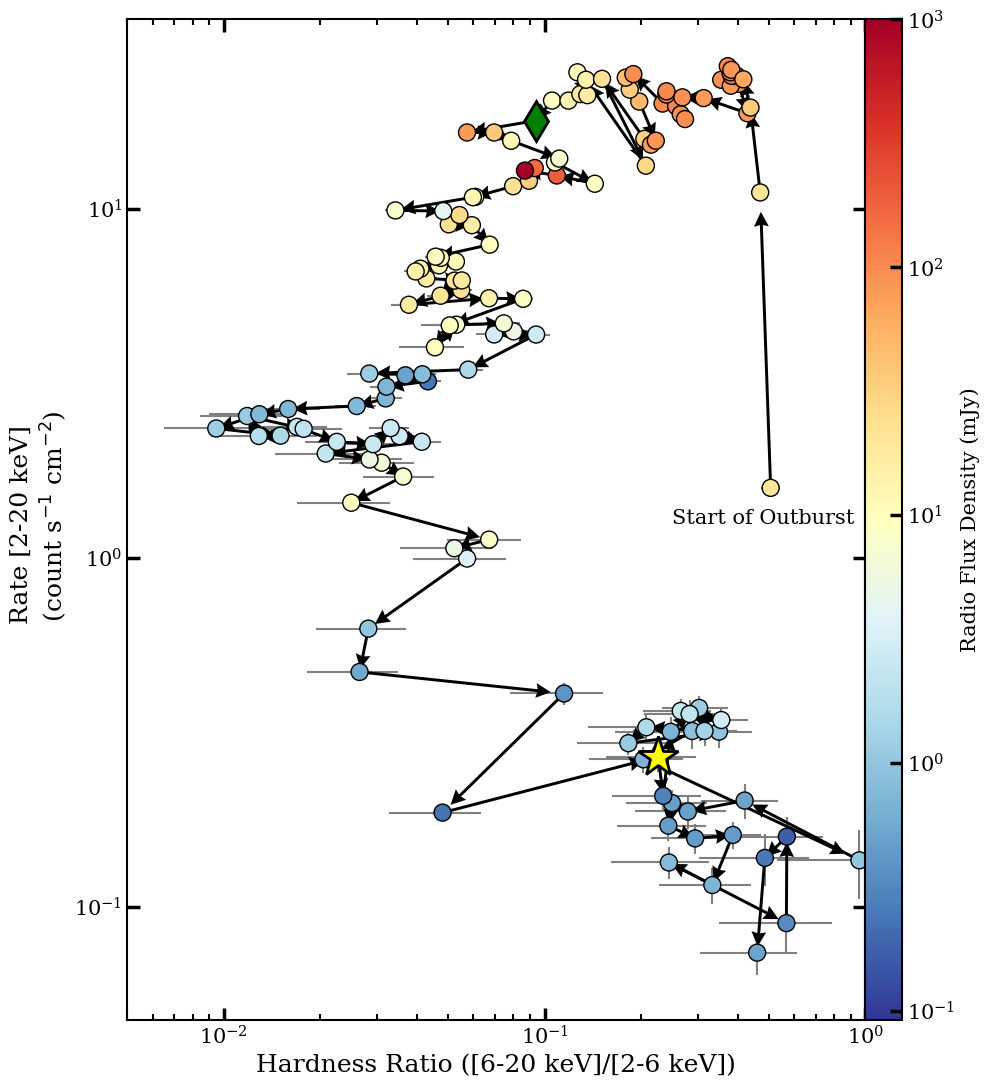

In [18]:
# Transition times
hard_to_soft = Time('2023-10-05T12:00:00', format='isot') # ATel 16273
soft_to_hard = Time('2024-03-15T12:00:00', format='isot') # Atel 16541

# Initialize HID plot and colour bar
cm = mpl.colormaps['RdYlBu_r']
fig, ax = plt.subplots(1, figsize=(10,13))
fig.set_facecolor('white')
ax = np.atleast_1d(ax)

# This does nothing it was just a relic from past code
f = len(HID[:,0])

# Get the times and fluxes to include radio flux as a colour bar
radio_t = data['Midpoint (MJD)'][scaled_index]
radio_f = flux_scaled[scaled_index]
radio_HID = np.interp(HID[:f,0], radio_t, radio_f)
radio_HID[radio_HID > 1e3] = 1e3

# Arrows to represent Time-domain evolution
cplt = ax[0].scatter(HID[:f,2][::-1], HID[:f,4][::-1], c = radio_HID[::-1], zorder=10000, ec='k', cmap=cm, norm = 'log', s = 150)
ax[0].errorbar(HID[:f,2], HID[:f,4], xerr = HID[:f,3], yerr = HID[:f,5], fmt='.', zorder=100, color='grey')
ax[0].quiver(HID[:f-1,2], HID[:f-1,4], (HID[1:f,2] - HID[:f-1,2]), (HID[1:f,4] - HID[:f-1,4]),  scale_units='xy', angles='xy', scale=1.07, color='black', zorder = 1000, width=4e-3, headwidth = 5)
# ax[0].text(0.415, 1.25, 'Start of Outburst', bbox=dict(facecolor='none', edgecolor='k', pad=3.0))
ax[0].text(0.250, 1.25, 'Start of Outburst', bbox=dict(facecolor='none', edgecolor='white', pad=3.0))

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%',pad=0)
cbar = fig.colorbar(cplt, cax=cax, label="Radio Flux Density (mJy)")

# Plot transition times
index = np.argmin(abs(HID[:,0] - hard_to_soft.mjd))
ax[0].errorbar(HID[index,2], HID[index,4], fmt='d', c='green', ms=20, mec ='k', mew=2, zorder=1e6)

index = np.argmin(abs(HID[:,0] - soft_to_hard.mjd))
ax[0].errorbar(HID[index,2], HID[index,4], fmt='*', c='yellow', ms=30, mec ='k', mew=2, zorder=1e6)

# Make the plot pretty
ax[0].set_ylabel('Rate [2-20 keV] \n (count s$^{-1}$ cm$^{-2}$)', fontsize=18)
ax[0].set_xlabel(r'Hardness Ratio $\left(\frac{[\text{6-20 keV}]}{[\text{2-6 keV}]}\right)$', fontsize=18)
ax[0].set_xlabel(r'Hardness Ratio ([6-20 keV]/[2-6 keV])', fontsize=18)

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].tick_params(labelbottom=True)

#ax[0].legend()
ax[0].set_xlim(5e-3,1)
plt.show()

## Plot the giant (some would say MONOLITHIC) radio light curve from all of the data

/tmp/ipykernel_9975/951613067.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(xlabels, rotation=15, ha='left')


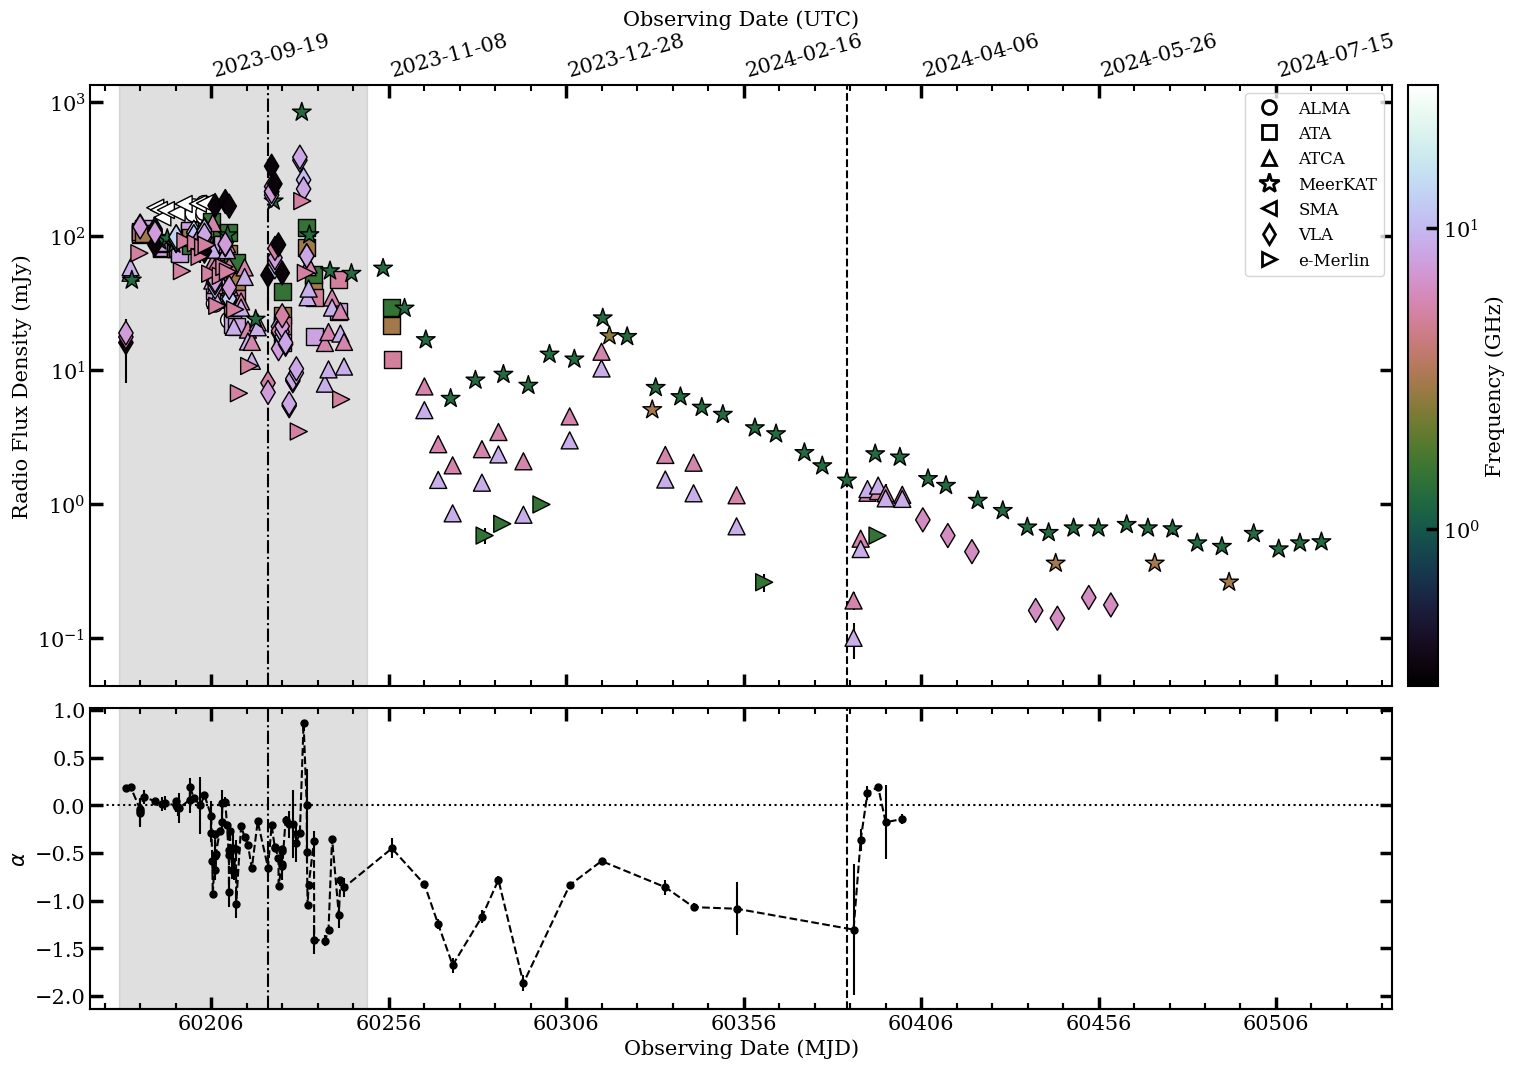

In [21]:
from matplotlib.lines import Line2D

# Stupid matplotlib sh*t from here -- https://stackoverflow.com/questions/46694889/matplotlib-sharex-with-colorbar-not-working
def align_axis_x(ax, ax_target):
    """Make x-axis of `ax` aligned with `ax_target` in figure"""
    posn_old, posn_target = ax.get_position(), ax_target.get_position()
    ax.set_position([posn_target.x0, posn_old.y0, posn_target.width, posn_old.height])


# Initialize the plot
fig, ax = plt.subplots(2, figsize=(20,12), sharex=True, gridspec_kw={'hspace': 0.05, 'height_ratios': [1.0, 0.5]})#, 'width_ratios': [1.0, 0.9]})
ax = np.atleast_1d(ax)

# Symbol, marker size, and color map choices -- Colour map is for frequency
symbol = ['o', 's' , '^', '*', '<', 'd', '>']
ms     = [150, 150, 150, 200, 150, 150, 150]
cm = mpl.colormaps['cubehelix']


# Radio Flux Densities in Top Panel
z = 0 
for k, tele in enumerate(np.unique(data['Telescope'])):
    index = np.where(data['Telescope'] == tele)[0]
    cplt = ax[0].scatter(data['Midpoint (DT)'][index], data['Integrated flux (mJy)'][index], c = data['Frequency (GHz)'][index], zorder=10000, ec='k', cmap=cm, norm = 'log', s = ms[k], label = f'{tele}', marker=symbol[k], vmin=0.3, vmax=30.)
    ax[0].errorbar(data['Midpoint (DT)'][index], data['Integrated flux (mJy)'][index], data['Error (mJy)'][index], fmt='.', ecolor='k')   
    z += 1


# Spectral Indices in Bottom Panel
alpha_index = np.argsort(alpha_mjd) # Sort by time
ax[1].errorbar(Time(alpha_mjd[alpha_index], format='mjd').datetime, alpha_arr[alpha_index], alpha_err_arr[alpha_index], fmt = 'o--', mec='k', ecolor='k', color='k', ms = 5)
ax[1].axhline(0.0, ls = ':', c='k')


# Highlight reported state transitions in both plots
for ax_i in ax:    
    ax_i.axvline(Time(60385, format='mjd').datetime, ls='--', c = 'k')
    ax_i.axvline(Time(60222, format='mjd').datetime, ls='-.', c = 'k')
    ax_i.axvspan(Time(60180, format='mjd').datetime, Time(60250, format='mjd').datetime, color='grey', alpha = 0.25) # This region highlights the 'zoom' in the next cell

# Manually specify legend elements and add formatting to axis
legend_elements = [Line2D([0], [0], marker='o', color='w', label='ALMA', mec ='k', mfc='w', mew=2, markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='ATA', mec ='k', mfc='w', mew=2, markersize=10),
                   Line2D([0], [0], marker='^', color='w', label='ATCA', mec ='k', mfc='w', mew=2, markersize=10),
                   Line2D([0], [0], marker='*', color='w', label='MeerKAT', mec ='k', mfc='w', mew=2, markersize=15),
                   Line2D([0], [0], marker='<', color='w', label='SMA', mec ='k', mfc='w', mew=2, markersize=10),
                   Line2D([0], [0], marker='d', color='w', label='VLA', mec ='k', mfc='w', mew=2, markersize=10),
                   Line2D([0], [0], marker='>', color='w', label='e-Merlin', mec ='k', mfc='w', mew=2, markersize=10)]

ax[0].legend(handles=legend_elements, fontsize=12, ncol=1)
ax[0].set_yscale('log')
ax[0].set_ylabel('Radio Flux Density (mJy)')
ax[1].set_ylabel(r'$\alpha$')
ax[1].tick_params(labelbottom = False)

# Format the color bar
fig.colorbar(cplt, ax=ax[0], label="Frequency (GHz)", shrink = 1, pad = 0.01)

# This is to include UTC on top and MJD on bottom (function is in first cell)
FormatAxis(ax, [data['Midpoint (MJD)'][0], data['Midpoint (MJD)'].iloc[-1] + 10], interval=50)
align_axis_x(ax[1], ax[0])
plt.show()

## Plot zoomed in Light Curve of rapid flaring

/tmp/ipykernel_9975/951613067.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(xlabels, rotation=15, ha='left')


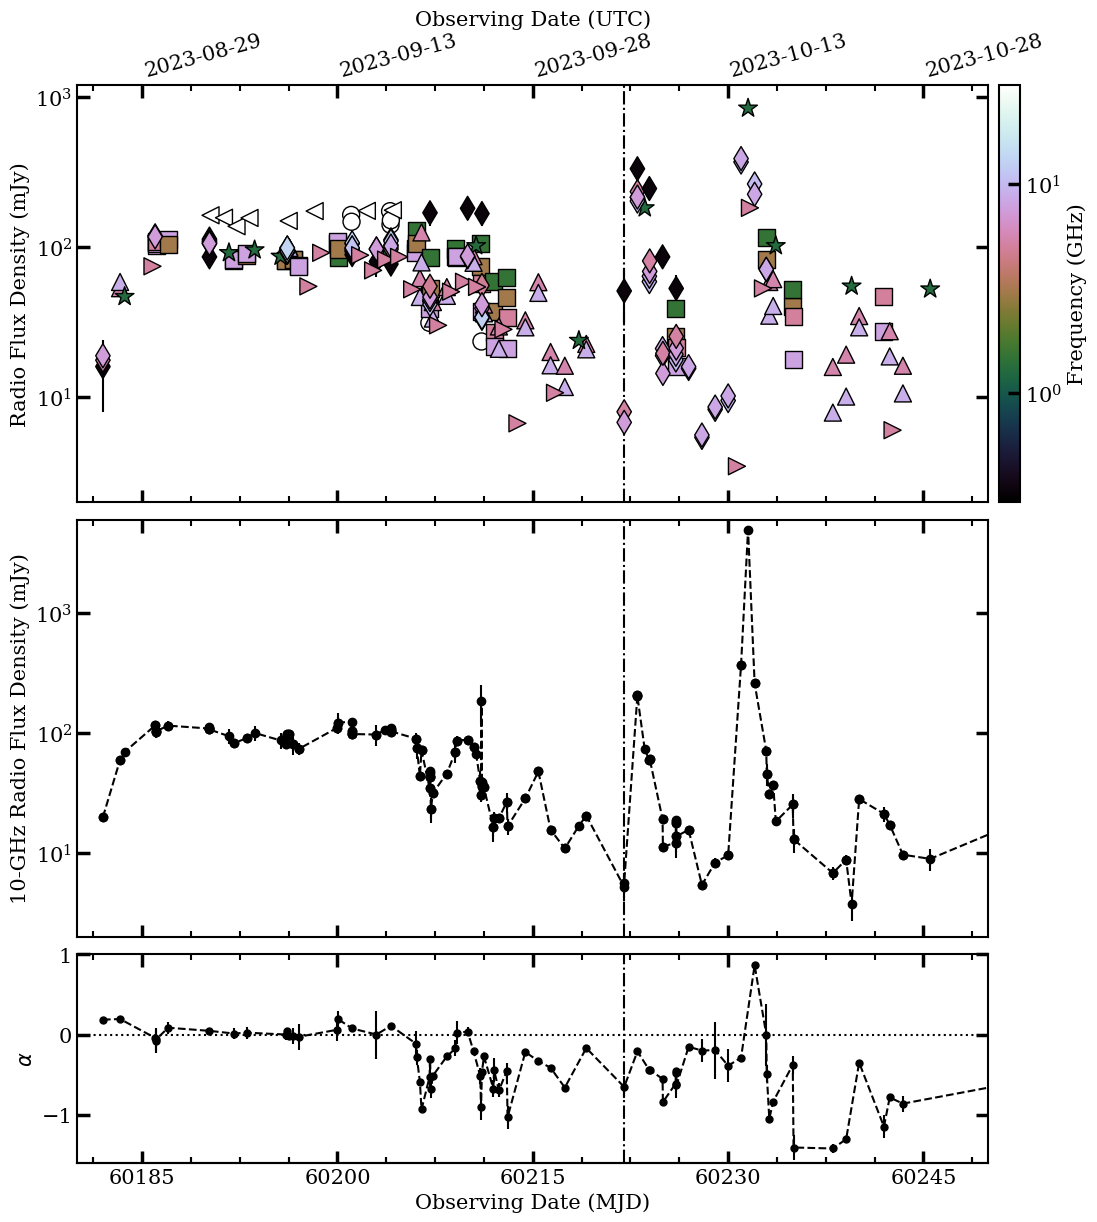

In [23]:
fig, ax = plt.subplots(3, figsize=(14,14), sharex='col', gridspec_kw={'hspace': 0.05, 'height_ratios': [1.0, 1.0, 0.5]})
ax = np.atleast_1d(ax)

# Flux Densities 
z = 0 
for k, tele in enumerate(np.unique(data['Telescope'])):
    index = np.where(data['Telescope'] == tele)[0]
    cplt = ax[0].scatter(data['Midpoint (DT)'][index], data['Integrated flux (mJy)'][index], c = data['Frequency (GHz)'][index], zorder=10000, ec='k', cmap=cm, norm = 'log', s = ms[k], label = f'{tele}', marker=symbol[k], vmin=0.3, vmax=30.)
    ax[0].errorbar(data['Midpoint (DT)'][index], data['Integrated flux (mJy)'][index], data['Error (mJy)'][index], fmt='.', ecolor='k')   
    z += 1  

# Mark state transitions
for ax_i in ax:    
    ax_i.axvline(Time(60385, format='mjd').datetime, ls='--', c = 'k')
    ax_i.axvline(Time(60222, format='mjd').datetime, ls='-.', c = 'k')

# Scaled Flux densities
ax[1].errorbar(data['Midpoint (DT)'][scaled_index], flux_scaled[scaled_index], flux_scaled_err[scaled_index], color='k', fmt='o--')


# Spectral Indices
alpha_index = np.argsort(alpha_mjd) # Sort by time
ax[2].errorbar(Time(alpha_mjd[alpha_index], format='mjd').datetime, alpha_arr[alpha_index], alpha_err_arr[alpha_index], fmt = 'o--', mec='k', ecolor='k', color='k', ms = 5)
ax[2].axhline(0.0, ls = ':', c='k')

# Formatting nonsense
ax[0].set_yscale('log')
ax[0].set_ylabel('Radio Flux Density (mJy)')
ax[0].set_ylim(2.0,1200)

ax[1].set_yscale('log')
ax[1].set_ylabel('10-GHz Radio Flux Density (mJy)')
ax[1].set_ylim(2.0,6000)

ax[2].set_ylabel(r'$\alpha$')
ax[2].set_ylim(-1.6,1.0)
ax[2].tick_params(labelbottom = False)
FormatAxis(ax, [60180, 60250], dt = 0, interval=15)

fig.colorbar(cplt, ax=ax[0], label="Frequency (GHz)", shrink = 1, pad = 0.01)
align_axis_x(ax[1], ax[0])
align_axis_x(ax[2], ax[0])
plt.show()